# <center><u>Sentiment Based Product Recommendation System </u></center>
__Author:__
- Anirudh Grover

# Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

 

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

 

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

 

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

 

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

- Data sourcing and sentiment analysis
- Building a recommendation system
- Improving the recommendations using the sentiment analysis model
- Deploying the end-to-end project with a user interface

## Importing required libraries

In [1]:
import re
import pandas as pd
import numpy as np
import nltk, spacy
from wordcloud import WordCloud, STOPWORDS
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Setting default style for plots
plt.style.use("bmh")

import warnings
warnings.filterwarnings('ignore')

# 1. Data Sourcing
We will load our dataset into our notebook.

In [2]:
# Reading the dataset
productDataset = pd.read_csv('sample30.csv')

# Inspecting the head of datatset
productDataset.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [3]:
# Checking the shape of dataframe
productDataset.shape

(30000, 15)

From above cell outputs we can see we have a dataset containing order details along with product details and reviews. We have 30K reviews. We also have a feature which tells us whether the review is positive or negative, which will ultimately help us in building the sentiment classifier.

# 2. Exploratory Data Analysis
Since, we have loaded our data into a dataframe. Now, we will perform some analysis on our data to understand it better.

### Proportion of Postive & Negative Reviews

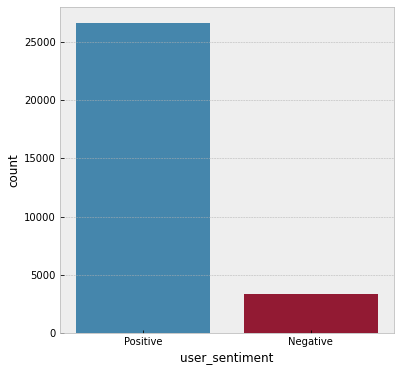

Positive    0.887763
Negative    0.112237
Name: user_sentiment, dtype: float64

In [4]:
# Plotting proportion of positive & negative reviews
plt.figure(figsize= (6,6))
sns.countplot(x='user_sentiment', data= productDataset)
plt.show()
productDataset['user_sentiment'].value_counts(1)

We can see from the above plot that we have a class imbalance problem. Almost __90% of our reviews are positive__ and the rest 10% are negative.

Now, let's analyze the ratings distribution.

### Reviews Rating Distribution 

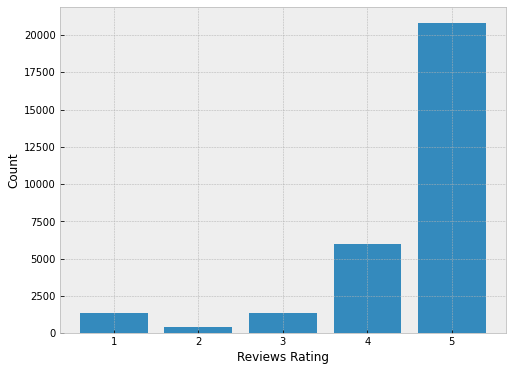

In [5]:
# Preparing a list of ratings and their respective counts
ratings = list(productDataset['reviews_rating'].value_counts().index)
ratingCounts = list(productDataset['reviews_rating'].value_counts())

# Plotting rating distribution
plt.figure(figsize=(8,6))
plt.bar(x=ratings, height=ratingCounts)
plt.xlabel('Reviews Rating')
plt.ylabel('Count')
plt.show()

There's a huge number of reviews with a 5 star rating, followed by 4 star rating. This is very much understandable as we generally like the product or don't like it at all. People who find the product perfect rate it 5, and the people who love it but look for some improvements rate it 4. There are also cases where the product is not good at all and they fall with the rating of 1.

<mark>We can also observe that __since 90% of ratings are postive, most of the reviews are 5 star.__ This validates our previous observation.</mark>

Now, let's look at the unique counts for each column to see what features we can visualize.

In [6]:
# Printing unique values for all the columns
productDataset.nunique()

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

Most of the columns are having huge number of unique values. Hence, we will be skipping them.

Let's analyze __reviews_doRecommend__.

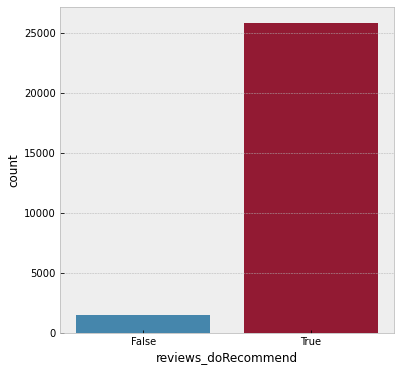

True     0.943493
False    0.056507
Name: reviews_doRecommend, dtype: float64

In [7]:
# Plotting proportion of recommended products
plt.figure(figsize= (6,6))
sns.countplot(x='reviews_doRecommend', data = productDataset)
plt.show()
productDataset['reviews_doRecommend'].value_counts(1)

We can see that there are huge proportion of products that got recommended by users. <br>
<mark>This plot looks somewhat similar to to what we got for the __user sentiments__ (Also, if we combine the higher ratings we would see somewhat similar plot).</mark>

We can validate the same by plotting them together. Let's analyze __reviews_doRecommend__ and __reviews_rating__ together.

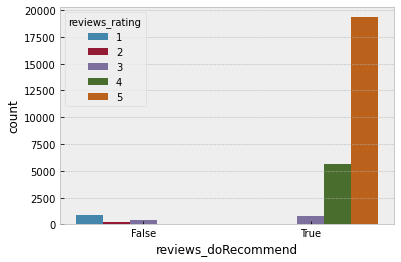

<Figure size 1080x864 with 0 Axes>

In [8]:
# Plotting Reviews Do Recommend and Reviews Rating
sns.countplot(x='reviews_doRecommend',hue='reviews_rating', data=productDataset)
plt.figure(figsize=(15,12))
plt.show()

We can infer from the above plot that __products with high rating tend to get recommended by the users___ to other people. This can be clearly seen in the above plot.

We will now analyze __reviews_didPurchase__ column.

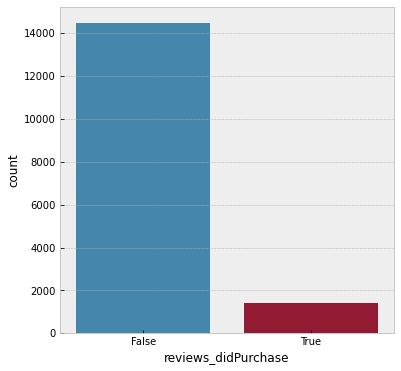

False    0.909992
True     0.090008
Name: reviews_didPurchase, dtype: float64

In [9]:
# Plotting proportion of purchased products
plt.figure(figsize= (6,6))
sns.countplot(x='reviews_didPurchase', data = productDataset)
plt.show()
productDataset['reviews_didPurchase'].value_counts(1)

We can see that there are huge proportion of products that didn't got purchased by users. <br>
Let's deep dive and plot it together with ratings and recommended products.

Let's analyze __reviews_didPurchase__ and __reviews_rating__ together.

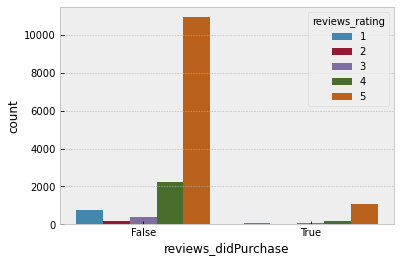

<Figure size 1080x864 with 0 Axes>

In [10]:
# Plotting Reviews Did Purchase and Reviews Rating
sns.countplot(x='reviews_didPurchase',hue='reviews_rating', data=productDataset)
plt.figure(figsize=(15,12))
plt.show()

We can infer that we are having most of the non-purchased items are for the items with high rating. This is obivious as most of the products are with high rating and hence most of the high rated products are not purchased.
 
Now, we should also analyze the textual column i.e. __reviews_text__ to understand which words are most common in the reviews. We can use __WordCloud__ for the same.

### WordCloud over all the Reviews

In [11]:
# Generating corpus from all the reviews
reviewTextCorpus = ''
for review in tqdm(productDataset['reviews_text']):
    reviewTextCorpus += " "+review

100%|█████████████████████████████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 12070.89it/s]


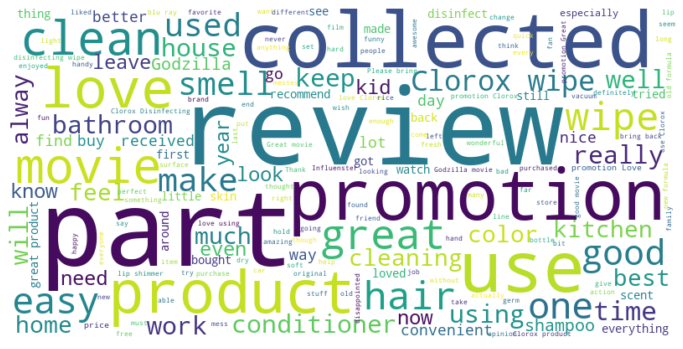

In [12]:
# Generating WordCloud from the text corpus
wordcloud = WordCloud(background_color='white',
                      stopwords=STOPWORDS, 
                      max_words=500, 
                      max_font_size=64,
                      scale=2,
                      random_state=128).generate(reviewTextCorpus)

# Displaying the WordCloud
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

From this cloud, the tokens (or words) font size is proportional to their frequency in the corpus i.e. __review__, __collected__, __promotion__  are some of the most frequent words. This can help us understand the most common words in our reviews.

Now, we have understood a lot about our datase. We should now proceed with __Data Cleaning__.

# 3. Data Cleaning
Let's now proceed with Data Cleaning to make our textual data ready to train a sentiment classifier.

We will start with checking for missing values.

In [13]:
# Checking number of NaN values for all columns
round(productDataset.isnull().sum()*100/productDataset.shape[0], 2)

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

It can be seen from the above cell output:
1. __reviews_userProvince__ is having almost 99% missing values. We can't impute it, hence will be dropped.
2. __reviews_userCity__ is having almost 94% missing values, we will also drop it.
3. __reviews_didPurchase__ is having relatively less missing values i.e. 47%. It will not be possible to impute the missing values as we can't know if someone purchased a product or not. We will also drop it.

In [14]:
# Dropping the above mentioned columns
productDataset.drop(['reviews_userProvince','reviews_userCity','reviews_didPurchase'], axis=1, inplace=True)

Now, let's look at the remaining columns having missing values to plan the next steps.

In [15]:
# Printing the count of null values for each columns
productDataset.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            1
dtype: int64

We can proceed with the following steps:
1. __manufacturer__ can be imputed by using the mode of the __manfacturer__ for the corresponding brand.
2. __reviewsdoRecommend__ can be imputed as True for products with high rating i.e. >=3.
3. __reviews_username__ can't be imputed directly using mode as this will create wrong data. We will impute it with "unspecified".
4. __user_sentiment__ has only 1 missing value. It can be imputed by looking at the rating provided by user. If rating is high i.e. >2, then it can be considered as a positive review else negative.
5. For __reviews_date__ and __reviews_title__, these columns can't be imputed directly. Also, they won't be relevant for our analysis as we are not considering date of the review and title is not required as text will tell us the sentiment. Hence, dropping.

__Imputing manufacturer with mode from that particular brand__

In [16]:
# Creating a list of brand
brandList = list(productDataset['brand'].unique())

# Imputing missing value for every brand
for brand in brandList:
    # Determining mode of manufacturer for every brand
    modeManufacturer = productDataset[productDataset['brand'] == brand]['manufacturer'].mode()[0]
    
    # Assigning mode manufacturer to all missing values in manufacturer column for that brand
    productDataset.loc[productDataset['brand'] == brand,'manufacturer'] = (productDataset
                                                                           .loc[productDataset['brand'] == brand,'manufacturer']
                                                                           .fillna(modeManufacturer)
                                                                          )
    
# Checking if the null values is handled
productDataset.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer              0
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            1
dtype: int64

__Imputing reviewsDoRecommend using reviews_rating__

In [17]:
## Fetching indexes where reviewsDoRecommend is NaN
nanRecommendIndex = productDataset[productDataset['reviews_doRecommend'].isna()].index

# Creating a series with the values to impute based on ratings
imputeValues = (productDataset
                .loc[nanRecommendIndex,'reviews_rating']
                .apply(lambda x:True if x>=3 else False)
               )


# Imputing reviewsDoRecommend
productDataset.loc[nanRecommendIndex,'reviews_doRecommend'] = imputeValues


# Checking if the null values is handled
productDataset.isnull().sum()

id                       0
brand                    0
categories               0
manufacturer             0
name                     0
reviews_date            46
reviews_doRecommend      0
reviews_rating           0
reviews_text             0
reviews_title          190
reviews_username        63
user_sentiment           1
dtype: int64

We have also handled missing values for __reviews_doRecommend__ column.

Now, let's impute __user_sentiment__.

__Imputing user_sentiment based on reviews_rating__

In [18]:
# Fetching indexes where user_sentiment is NaN
nanSentimentIndex = productDataset[productDataset['user_sentiment'].isna()].index

# Imputing user_sentiment
productDataset.loc[nanSentimentIndex,'user_sentiment'] = (productDataset
                                                          .loc[nanSentimentIndex,'reviews_rating']
                                                          .apply(lambda x:'Positive' if x>=3 else 'Negative')
                                                         )

# Checking if the null values is handled
productDataset.isnull().sum()

id                       0
brand                    0
categories               0
manufacturer             0
name                     0
reviews_date            46
reviews_doRecommend      0
reviews_rating           0
reviews_text             0
reviews_title          190
reviews_username        63
user_sentiment           0
dtype: int64

__NOTE__ : There can be also some cases which have wrong sentiment tagged i.e. rating could be high and sentiment might be marked as negative. We should fix these scenarios if they exist.

In [19]:
# Checking if high rated product have negatively tagged reviews
productDataset[(productDataset['reviews_rating']>=3) & (productDataset['user_sentiment']=='Negative')]

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
19,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-07T00:00:00.000Z,False,3,It was my first time using k-y. It didn't do a...,First time using,browns fan,Negative
42,AV1h6Gu0glJLPUi8IjA_,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,...",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2014-11-05T00:00:00.000Z,True,3,You would think it's convenient to have bubble...,It's bubble bath.,gardenbunny318,Negative
83,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2016-08-05T00:00:00.000Z,True,3,I would recommend this product to those who do...,This product is an oldie but goodie!,preacherjackson1,Negative
92,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-05-26T00:00:00.000Z,True,4,It hydrates my skin. It is not too thick and h...,hydrating but not too heavy,janicec,Negative
96,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-05-26T00:00:00.000Z,True,4,In only a week I can see the difference in my ...,This product has made a real difference on my ...,deedeedeedeesqr,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
29818,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2016-12-21T00:00:00.000Z,True,5,I received a complimentary sample of this prod...,Great Product,cindi d,Negative
29855,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-14T00:00:00.000Z,True,5,This has prolonged the color in my hair! Not o...,Great,meghanz,Negative
29858,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2016-12-30T00:00:00.000Z,True,5,This conditioner makes my hair very soft witho...,Makes my hair soft and shiny without excess oil!,melissa7390,Negative
29862,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-18T00:00:00.000Z,True,5,This conditioner has become a staple in my hai...,Great Conditioner,kacils,Negative


__From the above cell output we can see there are lot of records (i.e. 2630) which have high rating but have tagged as negative sentiment. Let's fix them using the same rule we used for fixing missing sentiments.__

In [20]:
# Setting user_sentiment as Positive for reviews that are having high rating i.e. 3 or above
productDataset['user_sentiment'] = (productDataset
                                      .loc[:,'reviews_rating']
                                      .apply(lambda x:'Positive' if x>=3 else 'Negative')
                                     )

# Checking if the issue is resolved
productDataset[(productDataset['reviews_rating']>=3) & (productDataset['user_sentiment']=='Negative')]

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment


In [21]:
# Looking at sentiment ratio
productDataset['user_sentiment'].value_counts(1)

Positive    0.939867
Negative    0.060133
Name: user_sentiment, dtype: float64

The issue is resolved now. We can proceed with the next step.

__Imputing reviews_username as unspecified__

In [22]:
# Imputing reviews username as unspecified for NaN values
productDataset['reviews_username'].fillna('unspecified', inplace=True)

# Checking if the null values is handled
productDataset.isnull().sum()

id                       0
brand                    0
categories               0
manufacturer             0
name                     0
reviews_date            46
reviews_doRecommend      0
reviews_rating           0
reviews_text             0
reviews_title          190
reviews_username         0
user_sentiment           0
dtype: int64

Now, we are left with 2 columns i.e.
1. reviews_date
2. reviews_title

We will drop these as these can't be imputed nor they contain much relevant information. Though, we can use __reviews_title__ content along with the actual reviews text to use them for sentiment analysis.

__Dropping/Fixing reviews_date & reviews_title__<br>
We will first replace NaN values for __reviews_title__ with blank values. After this, we will append __reviews_text__ to it.

In [23]:
# Filling NaN in reviews title with blank
productDataset['reviews_title'].fillna('', inplace=True)

# Appending reviews title to reviews text at the start of string
productDataset['reviews_text'] = productDataset['reviews_title'] + ' ' + productDataset['reviews_text']

In [24]:
# Dropping columns no longer needed
productDataset.drop(["reviews_date","reviews_title"], axis=1, inplace=True)

# Checking if the null values are handled
productDataset.isnull().sum()

id                     0
brand                  0
categories             0
manufacturer           0
name                   0
reviews_doRecommend    0
reviews_rating         0
reviews_text           0
reviews_username       0
user_sentiment         0
dtype: int64

We will now check the list of columns in our dataset to choose which columns are required for building our __Sentiment Classifier__ model.

In [25]:
# Looking at all the columns
productDataset.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name',
       'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_username', 'user_sentiment'],
      dtype='object')

Here, our first goal is to build a __Sentiment Classifier__ to classify whether the review is having positive or negative sentiment. This will only require the reviews from users and their corresponding sentiment.

<mark>Hence, we will only require two columns for training a Sentiment Classifier i.e. __reviews_text__ and __user_sentiment__.</mark>

In [234]:
# Retaining reviews_text & user_sentiment for building Sentiment Classifier
productDataset_sentiment = productDataset[['reviews_text','user_sentiment']]

# Inspecting a sample of dataframe
productDataset_sentiment.sample(5)

,reviews_text,user_sentiment
707,no longer a good glass cleaner Windex used to ...,Negative
16480,The only lip shimmer I wear I love these lip s...,Positive
29542,Smells Great The conditioner keeps my hair rea...,Positive
26621,It Works If You Use It! We traveled from WI to...,Positive
28361,awesome movie I bought this for two young boys...,Positive


Now, our data is ready for Sentiment Classifier. We will now preprocess the data in order to use it for building the model.

# 4. Text Preprocessing
Let's now proceed with Text Preprocessing to make our textual part ready to train a sentiment classifier.<br>
We will perform the following tasks:
1. Punctuations removal
2. Lowercasing text content
3. Extra spaces removal
4. Lemmatization
5. Stopwords removal

We will define a function to perform all this operations in the defined sequence.<br>
<mark>__NOTE__: Stopword removal is after lemmatization as we need POS tag for accurate lemmatization of texts.</mark>

In [235]:
# Importing stopwords
from nltk.corpus import stopwords

# Loading spaCy Model for PoS Tagging and Lemmatization
spacy_model = spacy.load('en_core_web_sm', disable=['parser','ner'])

# Defining function for preprocessing text
def preprocess_text(text_data):
    '''
    This function will perform the following operations on a text data:
    1. Punctuations removal
    2. Lowercasing text content
    3. Extra spaces removal
    4. Lemmatization
    5. Stopwords removal
    '''
    # Removing Punctuations
    text_data = re.sub('[^\w\s]','', text_data)
    
    # Converting to lowercase
    text_data = text_data.lower()
    
    
    # Now removing extra spaces at either ends of text
    text_data = text_data.strip()
    # Replacing multiple whitespaces between words with single whitespace
    text_data = re.sub('\s+',' ', text_data)
    
    # Initializing a list for storing lemmatized tokens
    lemmatizedTokens = []
    
    # Applying spacy model to textual data
    processedText = spacy_model(text_data)
    
    # Lemmatizing the text using spaCy
    for token in processedText:
        lemmatizedTokens.append(token.lemma_)
        
    # Removing stop words and storing the lemmatized tokens
    processedTokens = [token for token in lemmatizedTokens if not token in set(stopwords.words('english'))]
    
    # Return processed text
    return " ".join(processedTokens)

We have created the function for processing text. Now, we will apply the same on the reviews text from the dataset and update the reviews with the processed reviews.

In [236]:
# Processing the reviews text
processedReviews = [preprocess_text(review) for review in tqdm(productDataset_sentiment['reviews_text'])]

# Updating the dataset to contain processed reviews
productDataset_sentiment['reviews_text'] = processedReviews

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [08:24<00:00, 59.45it/s]


In [237]:
# Inspecting a sample of dataset
productDataset_sentiment.sample(5)

,reviews_text,user_sentiment
24251,ok movie movie ok good movie I purchase,Positive
8217,easy use I love clean kitchen bathroom counter...,Positive
4665,litty I nt know everyone else I always think r...,Positive
6779,clorox wipe awesome cleaner strong enough kill...,Positive
99,22 product really help skin feel soft youthful...,Positive


We have sucessfully preprocesed our reviews and cleaned it for feature extraction. Before performing feature extraction, we will split the data into Train and Test sets.

##  Train-Test Split

In [238]:
# Importing Train Test Split from sklearn
from sklearn.model_selection import train_test_split

sentimentData_train, sentimentData_test = train_test_split(productDataset_sentiment, 
                                                           train_size=0.75, 
                                                           stratify=productDataset_sentiment['user_sentiment'],
                                                           random_state=128)

print("Train Data Shape: {}".format(sentimentData_train.shape))
print("Test Data Shape: {}".format(sentimentData_test.shape))

Train Data Shape: (22500, 2)
Test Data Shape: (7500, 2)


We can now proceed to next step i.e. Feature Extraction.

# 5. Feature Extraction
We will now convert the raw texts to a matrix of TF-IDF features

__max_df__ is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the reviews"

__min_df__ is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 reviews"

In [31]:
# Initialising the TfidfVectorizer 
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

# Converting reviews text data to Tfidf Vector (Fit-Transform on Train and Fit on Test)
Tfidf_vector_train = vectorizer.fit_transform(sentimentData_train['reviews_text'])

In [32]:
# Printing TF-IDF Vector of product reviews
Tfidf_vector_train

<22500x7141 sparse matrix of type '<class 'numpy.float64'>'
	with 314770 stored elements in Compressed Sparse Row format>

We will now convert sentiment from  string to binary i.e. Positive as 1 and Negative as 0

In [33]:
# Converting Postive to 1 and Negative to 0
sentimentData_train['user_sentiment'] = sentimentData_train['user_sentiment'].apply(lambda x : 1 if x=='Positive' else 0)

# Checking the conversion
sentimentData_train['user_sentiment'].value_counts()

1    21147
0     1353
Name: user_sentiment, dtype: int64

# 6. Training a Text Classification Model
In this section, we will train multiple models for __Sentiment Classification__. Here, we will train the following models:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. Naive Bayes

In [26]:
# Importing Required Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
# Assigning values to X_train and y_train
X_train = Tfidf_vector_train
y_train = sentimentData_train['user_sentiment']

We can also perform the same for Test data. This will help us evaluate the models.

In [36]:
# Generating features for testing dataset using already fitted vectorizer
Tfidf_vector_test = vectorizer.transform(sentimentData_test['reviews_text'])

# Mapping user sentiment to 1 and O
sentimentData_test['user_sentiment'] = sentimentData_test['user_sentiment'].apply(lambda x : 1 if x=='Positive' else 0)

# Assigning values to X_test and y_test
X_test = Tfidf_vector_test
y_test = sentimentData_test['user_sentiment']

Now, we will train our ML models.

### 1. Logistic Regression

In [37]:
%%time
# Creating an instance of Logistic Regression
logit_model = LogisticRegression()

# Fitting the model on training dataset
logit_model.fit(X_train, y_train)

Wall time: 296 ms


LogisticRegression()

Let's see how our mode is performing on Train data

In [38]:
# Predicting using Training Data
y_train_pred= logit_model.predict(X_train)

# Printing the Accuracy of predictions
print("Logistic Regression Train Accuracy : ", round(accuracy_score(y_train, y_train_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_train, y_train_pred))

Logistic Regression Train Accuracy :  0.972

              precision    recall  f1-score   support

           0       0.97      0.56      0.71      1353
           1       0.97      1.00      0.99     21147

    accuracy                           0.97     22500
   macro avg       0.97      0.78      0.85     22500
weighted avg       0.97      0.97      0.97     22500



Let's evaluate the model on unseen data (i.e. test data)

In [39]:
# Predicting using Testing Data
y_test_pred= logit_model.predict(X_test)

# Printing the Accuracy of predictions
print("Logistic Regression Test Accuracy : ", round(accuracy_score(y_test, y_test_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_test, y_test_pred))

Logistic Regression Test Accuracy :  0.968

              precision    recall  f1-score   support

           0       0.95      0.50      0.66       451
           1       0.97      1.00      0.98      7049

    accuracy                           0.97      7500
   macro avg       0.96      0.75      0.82      7500
weighted avg       0.97      0.97      0.96      7500



It can be clearly seen from the above reports that prediction scores for Negative Class is relatively __very low__ compared to Postive Class.

__This is because, we have very less reviews with Negative sentiment as compared to Positive ones.__<br>
Let's validate the same by looking at the class distribution in our training dataset.

In [40]:
# Looking at class distribution for training data sentiments
sentimentData_train['user_sentiment'].value_counts(1)*100

1    93.986667
0     6.013333
Name: user_sentiment, dtype: float64

<mark>__Almost 94% of the reviews are Positive Reviews and only 6% of the reviews are having Negative sentiment. This is the problem of imbalanced class.__</mark><br><br>
It can be handled using __SMOTE__, which is a over sampling based technique for handling class imbalance. Let's import and use that and see if it helps.

In [41]:
# Importing SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE

# Initializing instance of SMOTE
smote = SMOTE()

# Resampling our training dataset using SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

We have now resampled the training dataset. Now, let's compare the class distribution before and after SMOTE.

In [42]:
from collections import Counter

counter = Counter(y_train)
print('Before',counter)

counter = Counter(y_train_smote)
print('After',counter)

Before Counter({1: 21147, 0: 1353})
After Counter({1: 21147, 0: 21147})


After SMOTE, our training dataset is perfectly balanced. We will now retrain our Logistic Regression model and check if there's any improvement.

In [43]:
%%time
# Recreating an instance of Logistic Regression
logit_model = LogisticRegression()

# Fitting the model on resampled training dataset
logit_model.fit(X_train_smote, y_train_smote)

Wall time: 548 ms


LogisticRegression()

Let's see how our model is performing on Train data

In [44]:
# Predicting using Training Data
y_train_pred= logit_model.predict(X_train_smote)

# Printing the Accuracy of predictions
print("Logistic Regression Train Accuracy : ", round(accuracy_score(y_train_smote, y_train_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_train_smote, y_train_pred))

Logistic Regression Train Accuracy :  0.977

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     21147
           1       0.98      0.97      0.98     21147

    accuracy                           0.98     42294
   macro avg       0.98      0.98      0.98     42294
weighted avg       0.98      0.98      0.98     42294



We can already see improvemens in training performance. Let's evaluate the model on unseen data (i.e. test data)

In [45]:
# Predicting using Testing Data
y_test_pred= logit_model.predict(X_test)

# Printing the Accuracy of predictions
print("Logistic Regression Test Accuracy : ", round(accuracy_score(y_test, y_test_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_test, y_test_pred))

Logistic Regression Test Accuracy :  0.952

              precision    recall  f1-score   support

           0       0.57      0.82      0.67       451
           1       0.99      0.96      0.97      7049

    accuracy                           0.95      7500
   macro avg       0.78      0.89      0.82      7500
weighted avg       0.96      0.95      0.96      7500



It is having a good performance, though somehow lacking for negative class. <br>
We can tune it more by changing the probability thresholds. We will create a function that will plot accuracy, sensitivity and specificity at various threshold. This will help us choose the optimum value.

In [46]:
# Defining a function to plot metrics for possible threshold values to identify optimum value
def optimumProabilityThreshold(actual, predictionProbabilities):
    # Creating a dataframe having target/actual values
    thresholdDF = pd.DataFrame(actual.values, columns=['Actual'])
    thresholdDF['PositiveSentiment_Prob'] = predictionProbabilities
    thresholdDF

    # Let's create columns with different probability cutoffs 
    num = list(np.arange(0.0,1.0,0.05))
    for i in num:
        thresholdDF[i]= thresholdDF['PositiveSentiment_Prob'].map(lambda x: 1 if x > i else 0)
     
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives
    
    num = list(np.arange(0.0,1.0,0.05))
    for i in num:
        cm1 = confusion_matrix(thresholdDF.Actual, thresholdDF[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])

        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)


    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

      prob  accuracy     sensi     speci
0.00  0.00  0.500000  1.000000  0.000000
0.05  0.05  0.795432  0.998771  0.592093
0.10  0.10  0.852650  0.997399  0.707902
0.15  0.15  0.895470  0.995933  0.795006
0.20  0.20  0.929564  0.994042  0.865087
0.25  0.25  0.950797  0.991819  0.909774
0.30  0.30  0.963990  0.988367  0.939613
0.35  0.35  0.971225  0.984064  0.958387
0.40  0.40  0.975434  0.979903  0.970965
0.45  0.45  0.976923  0.974937  0.978910
0.50  0.50  0.977160  0.969357  0.984962
0.55  0.55  0.975126  0.962311  0.987942
0.60  0.60  0.972147  0.953421  0.990873
0.65  0.65  0.966780  0.940464  0.993096
0.70  0.70  0.959190  0.923488  0.994893
0.75  0.75  0.950040  0.904005  0.996075
0.80  0.80  0.936870  0.876862  0.996879
0.85  0.85  0.917813  0.838275  0.997352
0.90  0.90  0.885114  0.772592  0.997636
0.95  0.95  0.821251  0.644252  0.998250


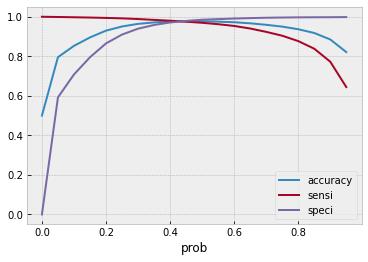

In [47]:
# Predicting using Training Data and saving the probabilities
y_train_pred_prob = logit_model.predict_proba(X_train_smote).T[1]

# Using above function to choose optimum threshold
optimumProabilityThreshold(y_train_smote, y_train_pred_prob)

In [48]:
# Using optimum threshold to label classes
y_train_pred = [1 if i>0.55 else 0 for i in y_train_pred_prob]

# Printing Classification Report for training data
print(classification_report(y_train_smote, y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     21147
           1       0.99      0.96      0.97     21147

    accuracy                           0.98     42294
   macro avg       0.98      0.98      0.98     42294
weighted avg       0.98      0.98      0.98     42294



In [49]:
# Predicting using Testing Data
y_test_pred_prob= logit_model.predict_proba(X_test).T[1]

# Using optimum threshold to label classes
y_test_pred = [1 if i>0.55 else 0 for i in y_test_pred_prob]

# Printing the Accuracy of predictions
print("Logistic Regression Test Accuracy : ", round(accuracy_score(y_test, y_test_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_test, y_test_pred))

Logistic Regression Test Accuracy :  0.944

              precision    recall  f1-score   support

           0       0.52      0.84      0.64       451
           1       0.99      0.95      0.97      7049

    accuracy                           0.94      7500
   macro avg       0.75      0.90      0.81      7500
weighted avg       0.96      0.94      0.95      7500



From the above cells, we are seeing some improvements. <br>
- __F1 Score__ : 95%
- __Precision__ : 96%
- __Recall__ : 94%
- __Recall for Negative Class__: 84%
- __Recall for Sentiment Class__: 95%

It's a great performance from a simple linear model. Also the model is not overfitting as training performance is close to the testing performance. <br>Now, let's try modeling with __Naive Bayes Classifier.__

### 2. Naive Bayes Classifier

In [50]:
# Importing Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

In [51]:
%%time

# Initializing an instance of Naive bayes
naive_bayes = MultinomialNB()

# Fitting on training data
naive_bayes.fit(X_train_smote, y_train_smote)

Wall time: 11 ms


MultinomialNB()

Model has fitted on training data. Now let's evaluate it on train and test data.

In [52]:
# Predicting using Training Data
y_train_pred = naive_bayes.predict(X_train_smote)

# Printing the Accuracy of predictions
print("Naive Bayes Train Accuracy : ", round(accuracy_score(y_train_smote, y_train_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_train_smote, y_train_pred))

Naive Bayes Train Accuracy :  0.946

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     21147
           1       0.96      0.94      0.95     21147

    accuracy                           0.95     42294
   macro avg       0.95      0.95      0.95     42294
weighted avg       0.95      0.95      0.95     42294



In [53]:
# Predicting using Testing Data
y_test_pred= naive_bayes.predict(X_test)

# Printing the Accuracy of predictions
print("Naive Bayes Test Accuracy : ", round(accuracy_score(y_test, y_test_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_test, y_test_pred))

Naive Bayes Test Accuracy :  0.918

              precision    recall  f1-score   support

           0       0.41      0.84      0.55       451
           1       0.99      0.92      0.96      7049

    accuracy                           0.92      7500
   macro avg       0.70      0.88      0.75      7500
weighted avg       0.95      0.92      0.93      7500



Naive Bayes is performing is having a decent performance. Though, we can tune it to get the best performance out of it.

In [54]:
# Importing libraries for tuning and creating folds for cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, random_state=128, shuffle=True)

In [55]:
%%time

# Initializing an instance of Naive bayes
naive_bayes = MultinomialNB()

# Creating a parameter dictionary for grid search
param_grid = {'alpha': np.arange(0, 1.05, 0.02)}

# Creating GridSearchCV object
naiveBayes_tuner = GridSearchCV(estimator = naive_bayes, 
                                param_grid = param_grid, 
                                scoring= 'f1',  
                                cv = folds, 
                                return_train_score = True,
                                n_jobs = -1,
                                verbose = 1)

# Fitting on training data
naiveBayes_tuner.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 53 candidates, totalling 265 fits
Wall time: 8.56 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04])},
             return_train_score=True, scoring='f1', verbose=1)

In [56]:
# Fetching the best model
naiveBayes_tuned = naiveBayes_tuner.best_estimator_

Finding out the optimum threshold.

      prob  accuracy     sensi     speci
0.00  0.00  0.500000  1.000000  0.000000
0.05  0.05  0.859082  0.997872  0.720291
0.10  0.10  0.894288  0.996170  0.792406
0.15  0.15  0.915496  0.993900  0.837093
0.20  0.20  0.928761  0.990873  0.866648
0.25  0.25  0.938975  0.987752  0.890197
0.30  0.30  0.946541  0.983260  0.909822
0.35  0.35  0.953610  0.979713  0.927507
0.40  0.40  0.958056  0.974181  0.941930
0.45  0.45  0.961035  0.968884  0.953185
0.50  0.50  0.961768  0.962926  0.960609
0.55  0.55  0.960656  0.954131  0.967182
0.60  0.60  0.959380  0.945051  0.973708
0.65  0.65  0.956708  0.934884  0.978531
0.70  0.70  0.951837  0.920982  0.982693
0.75  0.75  0.944815  0.903816  0.985814
0.80  0.80  0.937060  0.885043  0.989076
0.85  0.85  0.925001  0.858467  0.991535
0.90  0.90  0.907339  0.821630  0.993049
0.95  0.95  0.880361  0.764647  0.996075


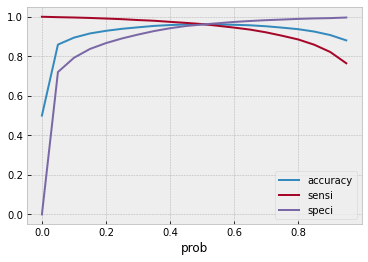

In [57]:
# Predicting using Training Data and saving the probabilities
y_train_pred_prob = naiveBayes_tuned.predict_proba(X_train_smote).T[1]

# Using above function to choose optimum threshold
optimumProabilityThreshold(y_train_smote, y_train_pred_prob)

Now, let's evaluate the tuned model and see it's performance.

In [58]:
# Using optimum threshold to label classes
y_train_pred = [1 if i>0.57 else 0 for i in y_train_pred_prob]

# Printing the Accuracy of predictions
print("Naive Bayes Train Accuracy : ", round(accuracy_score(y_train_smote, y_train_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_train_smote, y_train_pred))

Naive Bayes Train Accuracy :  0.961

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     21147
           1       0.97      0.95      0.96     21147

    accuracy                           0.96     42294
   macro avg       0.96      0.96      0.96     42294
weighted avg       0.96      0.96      0.96     42294



In [59]:
# Predicting using Testing Data
y_test_pred_prob= naiveBayes_tuned.predict_proba(X_test).T[1]

# Using optimum threshold to label classes
y_test_pred = [1 if i>0.57 else 0 for i in y_test_pred_prob]

# Printing the Accuracy of predictions
print("Naive Bayes Test Accuracy : ", round(accuracy_score(y_test, y_test_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_test, y_test_pred))

Naive Bayes Test Accuracy :  0.922

              precision    recall  f1-score   support

           0       0.41      0.67      0.51       451
           1       0.98      0.94      0.96      7049

    accuracy                           0.92      7500
   macro avg       0.69      0.80      0.73      7500
weighted avg       0.94      0.92      0.93      7500



We can see that our Naive Bayes classifier is having similar performance even after tuning.
- __F1 Score__ : 93%
- __Precision__ : 94%
- __Recall__ : 92%
- __Recall for Negative Class__: 67%
- __Recall for Sentiment Class__: 94%

This is having a decent performance. Though, __Logistic Regression performed much better__.<br>
We should now proceed with powerful class of models, i.e. __Ensemble Models__.

### 3. XGBoost Classifier

In [60]:
# Importing XGB Classifier
from xgboost import XGBClassifier

In [61]:
%%time

# Creating object of XGBClassifier
xgBoost = XGBClassifier(n_jobs=-1, random_state=128)

# Creating a parameter dictionary for grid search
param_grid = {'learning_rate': [0.001],
              'max_depth': [10, 15, 20],
              'n_estimators': [500, 1000, 2000]}

# Creating GridSearchCV object
xgBoost_tuner = GridSearchCV(estimator = xgBoost, 
                                  param_grid = param_grid, 
                                  scoring= 'f1',  
                                  cv = folds, 
                                  return_train_score = True,
                                  n_jobs = -1,
                                  verbose = 10)

# TAKES AROUND 6HRS ON i7 6500 (6th Gen) CPU
# Fitting on training data
xgBoost_tuner.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[06:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5h 54min 29s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_...
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=128, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                              

In [62]:
# Fetching the best model
xgBoost_tuned = xgBoost_tuner.best_estimator_

Finding out the optimum threshold.

      prob  accuracy     sensi     speci
0.00  0.00  0.500000  1.000000  0.000000
0.05  0.05  0.500000  1.000000  0.000000
0.10  0.10  0.867333  0.999953  0.734714
0.15  0.15  0.936800  0.999953  0.873646
0.20  0.20  0.959521  0.999953  0.919090
0.25  0.25  0.971391  0.999953  0.942829
0.30  0.30  0.979926  0.999905  0.959947
0.35  0.35  0.984324  0.999716  0.968932
0.40  0.40  0.986807  0.999196  0.974417
0.45  0.45  0.988178  0.998250  0.978106
0.50  0.50  0.989407  0.997163  0.981652
0.55  0.55  0.990164  0.995366  0.984962
0.60  0.60  0.989715  0.992245  0.987185
0.65  0.65  0.988367  0.987469  0.989266
0.70  0.70  0.985364  0.978768  0.991961
0.75  0.75  0.979453  0.965432  0.993474
0.80  0.80  0.966827  0.938053  0.995602
0.85  0.85  0.936989  0.875680  0.998298
0.90  0.90  0.830662  0.661370  0.999953
0.95  0.95  0.500000  0.000000  1.000000


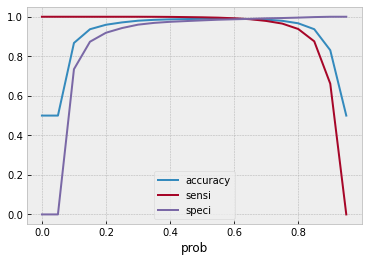

In [63]:
# Predicting using Training Data and saving the probabilities
y_train_pred_prob = xgBoost_tuned.predict_proba(X_train_smote).T[1]

# Using above function to choose optimum threshold
optimumProabilityThreshold(y_train_smote, y_train_pred_prob)

Now, let's evaluate the tuned model and see it's performance.

In [76]:
# Using optimum threshold to label classes
y_train_pred = [1 if i>0.68 else 0 for i in y_train_pred_prob]

# Printing the Accuracy of predictions
print("XGBoost Classifier Train Accuracy : ", round(accuracy_score(y_train_smote, y_train_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_train_smote, y_train_pred))

XGBoost Classifier Train Accuracy :  0.972

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     21147
           1       0.99      0.95      0.97     21147

    accuracy                           0.97     42294
   macro avg       0.97      0.97      0.97     42294
weighted avg       0.97      0.97      0.97     42294



In [77]:
# Predicting using Testing Data
y_test_pred_prob= xgBoost_tuned.predict_proba(X_test).T[1]

# Using optimum threshold to label classes
y_test_pred = [1 if i>0.68 else 0 for i in y_test_pred_prob]

# Printing the Accuracy of predictions
print("XGBoost Classifier Test Accuracy : ", round(accuracy_score(y_test, y_test_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_test, y_test_pred))

XGBoost Classifier Test Accuracy :  0.931

              precision    recall  f1-score   support

           0       0.45      0.74      0.56       451
           1       0.98      0.94      0.96      7049

    accuracy                           0.93      7500
   macro avg       0.72      0.84      0.76      7500
weighted avg       0.95      0.93      0.94      7500



We can see that our XGBoost Classifier is having below performance after tuning.
- __F1 Score__ : 94%
- __Precision__ : 95%
- __Recall__ : 93%
- __Recall for Negative Class__: 74%
- __Recall for Sentiment Class__: 94%

This is having a good performance. Though, __Logistic Regression performed much better__.<br>
We should also try Random Forest Classifier.

### 4. Random Forest Classifier

In [66]:
# Importing Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier 

In [67]:
%%time

# Initializing instance of Random Forest Classifier
randomForest =  RandomForestClassifier(n_jobs=-1, random_state=128)

# Creating a parameter dictionary for grid search
param_grid = {
              'n_estimators':[1000, 2000],
              'min_samples_split': [100, 200],
              'max_depth': [20,25],
              'max_features':[1500, 2000]
              }

# Creating GridSearchCV object
randomForest_tuner = GridSearchCV(estimator = randomForest, 
                                  param_grid = param_grid, 
                                  scoring= 'f1',  
                                  cv = folds, 
                                  return_train_score = True,
                                  n_jobs = -1,
                                  verbose = 10)
# TAKES AROUND 7HRS ON AN i7 6500 (6th GEN) CPU
# Fitting on training data
randomForest_tuner.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Wall time: 7h 5min 38s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=128),
             n_jobs=-1,
             param_grid={'max_depth': [20, 25], 'max_features': [1500, 2000],
                         'min_samples_split': [100, 200],
                         'n_estimators': [1000, 2000]},
             return_train_score=True, scoring='f1', verbose=10)

In [68]:
# Fetching the best model
randomForest_tuned = randomForest_tuner.best_estimator_

Finding out the optimum threshold.

      prob  accuracy     sensi     speci
0.00  0.00  0.500000  1.000000  0.000000
0.05  0.05  0.828534  1.000000  0.657067
0.10  0.10  0.893436  1.000000  0.786873
0.15  0.15  0.924103  1.000000  0.848205
0.20  0.20  0.946139  1.000000  0.892278
0.25  0.25  0.961815  0.999953  0.923677
0.30  0.30  0.971958  0.999905  0.944011
0.35  0.35  0.978366  0.999574  0.957157
0.40  0.40  0.983473  0.999007  0.967939
0.45  0.45  0.985128  0.997210  0.973046
0.50  0.50  0.986570  0.994373  0.978768
0.55  0.55  0.985341  0.988320  0.982362
0.60  0.60  0.981179  0.977444  0.984915
0.65  0.65  0.975859  0.963163  0.988556
0.70  0.70  0.968435  0.945382  0.991488
0.75  0.75  0.956613  0.920036  0.993191
0.80  0.80  0.943207  0.890954  0.995460
0.85  0.85  0.925119  0.852414  0.997825
0.90  0.90  0.887360  0.775902  0.998818
0.95  0.95  0.773798  0.547595  1.000000


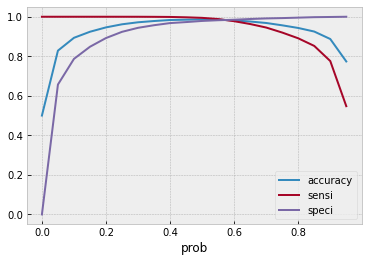

In [69]:
# Predicting using Training Data and saving the probabilities
y_train_pred_prob = randomForest_tuned.predict_proba(X_train_smote).T[1]

# Using above function to choose optimum threshold
optimumProabilityThreshold(y_train_smote, y_train_pred_prob)

Now, let's evaluate the tuned model and see it's performance.

In [74]:
# Using optimum threshold to label classes
y_train_pred = [1 if i>0.58 else 0 for i in y_train_pred_prob]

# Printing the Accuracy of predictions
print("Random Forest Train Accuracy : ", round(accuracy_score(y_train_smote, y_train_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_train_smote, y_train_pred))

Random Forest Train Accuracy :  0.983

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     21147
           1       0.98      0.98      0.98     21147

    accuracy                           0.98     42294
   macro avg       0.98      0.98      0.98     42294
weighted avg       0.98      0.98      0.98     42294



In [75]:
# Predicting using Testing Data
y_test_pred_prob= randomForest_tuned.predict_proba(X_test).T[1]

# Using optimum threshold to label classes
y_test_pred = [1 if i>0.58 else 0 for i in y_test_pred_prob]

# Printing the Accuracy of predictions
print("Random Forest Test Accuracy : ", round(accuracy_score(y_test, y_test_pred),3))
print("")

# Printing the Classification Report for getting a better view on performance
print(classification_report(y_test, y_test_pred))

Random Forest Test Accuracy :  0.94

              precision    recall  f1-score   support

           0       0.50      0.76      0.60       451
           1       0.98      0.95      0.97      7049

    accuracy                           0.94      7500
   macro avg       0.74      0.85      0.78      7500
weighted avg       0.95      0.94      0.95      7500



We can see that our Random Forest classifier is having good performance.
- __F1 Score__ : 95%
- __Precision__ : 95%
- __Recall__ : 94%
- __Recall for Negative Class__: 76%
- __Recall for Sentiment Class__: 95%

This is having a pretty good performance too. Though, __Logistic Regression performed much better__.<br>
We should compare these results of all 4 models and choose the best one.

## Choosing the best Sentiment Classifier
We have tested 4 models for Sentiment Classification. We will be choosing the best model out of these. We will compare the metrics for each of these model and choose the one which is having the best performance on unseen data.

From our analysis, we can see __Logistic Regression__ is having the best performance on unseen data and it is the one which is having the least variance.

- __F1 Score__ : 95%
- __Precision__ : 96%
- __Recall__ : 94%
- __Recall for Negative Class__: 84%
- __Recall for Sentiment Class__: 95%

Hence, we will be selecting our trained __Logistic Regression__ as our final model. We will be also keeping a track of the probability threshold for that model.

In [78]:
# Saving the probability threshold value used for Logistic Regression
probThreshold = 0.55

# Saving the Logistic Regression as the sentiment classifier model
finalSentimentClassifier = logit_model

### Saving Pickle Files for Model & Vectorizer
We will save our model and vectorizer as pickle for future use.

In [53]:
# Importing Pickle
import pickle

In [80]:
# Saving Model as Pickle File
modelFilePath = './pickle/sentimentClassifier_logit.pkl'
pickle.dump(finalSentimentClassifier, open(modelFilePath,'wb'))

# Saving Vectoizer as Pickle File
vectorizerFilePath = './pickle/vectorizer.pkl'
pickle.dump(vectorizer, open(vectorizerFilePath,'wb'))

We also need to save the __processed training data reviews__ to be used in Recommendation System that we will build next.

__NOTE:__ We also need to include the product name in this dataset to be able to use it as a key.

In [248]:
# Fetching the product names for the reviews in training data using index
processedProductReviewMapping = pd.DataFrame(productDataset.loc[sentimentData_train.index, 'name'])

# Creating a dataframe to store the required attributes
processedProductReviewMapping['reviews_text'] = sentimentData_train['reviews_text']

# Looking at a sample of created dataframe
processedProductReviewMapping.head()

,name,reviews_text
15218,Avery174 Ready Index Contemporary Table Of Con...,table content divider great product fast easy ...
13365,Clorox Disinfecting Wipes Value Pack Scented 1...,sick house hold I use week ago disinfect house...
21421,Nexxus Exxtra Gel Style Creation Sculptor,super sad hunt new gel I use gel many year sup...
10374,Clorox Disinfecting Wipes Value Pack Scented 1...,must great wipe handy spill kitchen need quick...
2887,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,wholesome entertainment even though great firs...


In [249]:
# Defining path for saving dataset
trainingDataPath = './dataset/processedTrainData.csv'

# Saving Processed Training Data Reviews
processedProductReviewMapping.reset_index(drop=True).to_csv(trainingDataPath)

We have now written the data to storage. The reviews from this dataset will be vectorized and used by Sentiment Model for recommendation purposes. Let's also save the cleaned version of the original dataset

In [250]:
# Defining path for saving dataset
cleanedDataPath = './dataset/cleanedProductData.csv'

# Saving Cleaned Data
productDataset.reset_index(drop=True).to_csv(cleanedDataPath)

We have now saved the cleaned data to storage as well. We will now proceed with Recommendation System

<hr>

# 7. Building a Recommendation System
We have our __Sentiment Classifier__ ready for use. Now, we will build a recommendation system which will recommend products to user using Collaborative Filtering technique.

We will build the following Recommendation Systems:
1. User-based Recommendation System
2. Item-based Recommendation System

Our task is to analyze both recommendation system and select the one which is best suited for this use case. Before building our recommendation system we need prepare our dataset for it.

In [96]:
# Inspecting the dataset
productDataset.head()

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),True,5,Just Awesome i love this album. it's very good...,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,5,Good Good flavor. This review was collected as...,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,5,Good Good flavor.,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,Disappointed I read through the reviews on her...,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,Irritation My husband bought this gel for us. ...,walker557,Negative


First, we will convert the data into train and test. 

After that, we will subset the data to contain the following columns only as others are not required for recommendation system.
1. reviews_username
2. name (i.e. name of product)
3. reviews_rating

In [27]:
# Performing Train and Test Split
from sklearn.model_selection import train_test_split

recommendation_train, recommendation_test = train_test_split(productDataset, 
                                                             train_size=0.75, 
                                                             stratify=productDataset['user_sentiment'],
                                                             random_state=128)

# Selecting the required columns
recommendation_train, recommendation_test = (recommendation_train[['name','reviews_rating','reviews_username']], 
                                             recommendation_test[['name','reviews_rating','reviews_username']])

print("Train Data Shape: {}".format(recommendation_train.shape))
print("Test Data Shape: {}".format(recommendation_test.shape))

Train Data Shape: (22500, 3)
Test Data Shape: (7500, 3)


Now, let's start building the recommendation systems

## 1. User-based Recommendation System

In this type of recommendation, similarity between different users is determined to recommend the items/products to different users.

So, we will need to create a dataframe which is having __users as index__ , __products as columns__ and __product rating as values__. We will use pivot operation of Pandas for the same.

In [28]:
# Creating a Pivot DF for user based recommendation 
recommendation_pivot = recommendation_train.pivot_table(index='reviews_username',
                                                        columns='name',
                                                        values='reviews_rating'
                                                       ).fillna(0)

# Inspecting the Pivot DF
recommendation_pivot.sample(5)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
wendydarling,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tbattin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
joeyg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pazmaniadevil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
droberts1014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating Dummy Train
This dataset will be used for prediction:<br>

    Dummy Train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The product not rated by user is marked as 1 for prediction in dummy train dataset. 

In [29]:
# Copy the training dataset into dummy_train
dummyTrain = recommendation_train.copy()

In [30]:
# Inspecting the copy
dummyTrain.head()

,name,reviews_rating,reviews_username
15218,Avery174 Ready Index Contemporary Table Of Con...,5,macduff
13365,Clorox Disinfecting Wipes Value Pack Scented 1...,5,kris6
21421,Nexxus Exxtra Gel Style Creation Sculptor,1,kase
10374,Clorox Disinfecting Wipes Value Pack Scented 1...,5,llimboy
2887,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,5,blklightsomnium


Now, we will update the ratings column to be marked as 1 if the product is not rated by the corresponding user.

In [31]:
# Products not rated by user is marked as 1 for prediction and the rated ones are marked as 0
dummyTrain['reviews_rating'] = dummyTrain['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [32]:
# Converting the dummy train dataset into a matrix format
dummyTrain = dummyTrain.pivot_table(index='reviews_username',
                                    columns='name',
                                    values='reviews_rating').fillna(1)

# Inspecting the dummy train dataset
dummyTrain.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Now, let's find move to the next step i.e. calculating user similarities.

### Generating User Similarity Matrix

We can use Cosine Similarity for calculating the similarity between users. Though, we will use another approach i.e. __Adjusted Cosine.__

__Cosine Similarity__

    Cosine Similarity is a measurement that quantifies the similarity between two vectors.

__Adjusted Cosine__

    Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user, we subtract average ratings for each user from each user's rating for different movies.

In [33]:
# Checking the number of unique users
recommendation_pivot.index.nunique()

19387

For Adjusted Cosine, we need to take the average of the user ratings. We will need to perform some extra steps for that.

Here, we are not removing the NaN values and calculating the mean only for the products rated by the user.

In [34]:
# Creating a user-product matrix.
recommendation_pivot = recommendation_train.pivot_table(index='reviews_username',
                                                        columns='name',
                                                        values='reviews_rating')

# Inspecting the head
recommendation_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Normalising the rating of the products for each user around 0 mean__

In [35]:
# Calculating the mean for non NaN ratings
mean_ratings = np.nanmean(recommendation_pivot, axis=1)

# Subtracting the mean from each rating to normalize
recommendation_pivot_subtracted = (recommendation_pivot.T - mean_ratings).T

# Printing the head of subtracted df
recommendation_pivot_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we're ready to calculate the __adjusted cosine similarity__

In [36]:
# Importing pairwise distances for cosine similarity calculation
from sklearn.metrics.pairwise import pairwise_distances

In [37]:
# Creating the User Similarity Matrix using pairwise_distance function
userCorrelationMatrix = 1 - pairwise_distances(recommendation_pivot_subtracted
                                          .fillna(0), 
                                          metric='cosine')

# Filling NaN values as 0
userCorrelationMatrix[np.isnan(userCorrelationMatrix)] = 0

# Printing the correlation matrix for all users
print(userCorrelationMatrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [38]:
# Checking the shape of user correlation matrix 
userCorrelationMatrix.shape

(19387, 19387)

Shape of User Correlation Matrix is correct, hence we can use it for prediction purpose.

### Prediction (User-User Correlation)
As our user-user correlation matrix is ready, we will now use that to predict the ratings for every user. Here, __we are predicting the product ratings for the users which are positively related with other users, and not the users which are negatively related__ as we are interested in the users which are more similar to the current users. 

So, we will be ignoring the correlation for values less than 0 in the next cell.

In [39]:
# Setting correlations less than 0 as 0
userCorrelationMatrix[userCorrelationMatrix < 0] = 0

# Printing the matrix
userCorrelationMatrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now, let's predict the ratings. Rating predicted by the user (for products rated as well as not rated) is the __weighted sum of correlation with the product rating (as present in the rating dataset).__ 

In [40]:
# Performing a dot product between user correlation matrix and users-product matrix
predictedRatings = np.dot(userCorrelationMatrix, 
                                recommendation_pivot.fillna(0)
                               )
# Printing the predicted ratings
predictedRatings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
# Checking the shape of predicted ratings matrix (it should be no. of unique users x no. of unique products)
predictedRatings.shape

(19387, 260)

The shape of predictedRatings matrix is correct. Though, we are interested only in the products not rated by the user, __we will ignore the products rated by the user by making it zero__.

For this, we will just multiply predicted ratings with the dummy train dataframe as this ignore the rated products by making them zero.

In [42]:
# Performing element-wise multiplication of predictedRatings and dummyTrain df
predictedRatings_final = np.multiply(predictedRatings, dummyTrain)

# Inspecting the final predicted ratings
predictedRatings_final.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are ready with the predicted ratings for the products __not__ rated by the user. This will help us get the product recommendation for users by sorting the products by their ratings.

### Finding the top 20 recommendations for users using User-based Recommendation System

In [43]:
# Taking username as input
input_username = input("Enter your username: "

Enter your username: 00dog3


We have the username now, we will filter the ratings with the username and sort the products w.r.t to their ratings in descending order to get the required recommendations.

In [44]:
# Fetching the product recommendations along with their ratings
predictedRatings_final.loc[input_username].sort_values(ascending=False)[0:20]

name
Yes To Grapefruit Rejuvenating Body Wash                                                        0.0
Heiress (dvd)                                                                                   0.0
Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1                                             0.0
Head & Shoulders Classic Clean Conditioner                                                      0.0
Hawaiian Punch Berry Limeade Blast Juice                                                        0.0
Happy Tot Apple and Butternut Squash                                                            0.0
Greyson Vintage Industrial Occasional Cocktail Coffee Table - Antique Bronze - Baxton Studio    0.0
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                                 0.0
Germ Guardian174 Elite 3-In-1 Pet Pure True Hepa Air Purifier Ac4300bptca                       0.0
Gain Original Scent Liquid Fabric Softener 129 Oz                                              

We have got the recommendations. However, __the ratings are all zero.__ We need to check the recommendations for another user to see if our recommendation system is working fine.

Let's pick a random user from all the usernames and check it's recommendation.

In [45]:
# Taking a random user = 'kitkat' and checking recommendations for that user
predictedRatings_final.loc['kitkat'].sort_values(ascending=False)[:20]

name
The Resident Evil Collection 5 Discs (blu-Ray)                                     42.914160
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                41.090454
Mike Dave Need Wedding Dates (dvd + Digital)                                       37.673587
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                               32.590516
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                          22.805782
Clorox Disinfecting Bathroom Cleaner                                               15.291701
Red (special Edition) (dvdvideo)                                                   14.224103
Tostitos Bite Size Tortilla Chips                                                  13.448770
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)                      12.227724
100:Complete First Season (blu-Ray)                                                10.479722
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)            

We can see this user __kitkat__ has non zero ratings for all the products. This tells us that our recommendation system is working fine.

<mark>We can say that __User Based Recommendation System__ is failing for some users as it is not able to find out correlation between them or only negative correlations for certain users, which is why the ratings are coming as zero for many users.</mark>

We need to check the same __Item Based Recommendation System__. However, we should evaluate this system first by calculating its RMSE on testing data. 

In [46]:
# Saving recommendations in a variable
userBasedRecommendations = predictedRatings_final

### Evaluation (User-User)
Evaluation will we same as we have done above for the prediction. The only difference being, we will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user.

First, we need to find out the common users between training and testing dataset.

In [47]:
# Finding out the common users of testing and training dataset
commonUsers = (recommendation_test[recommendation_test['reviews_username']
                                   .isin(recommendation_train['reviews_username'])])

# Looking at the shape
commonUsers.shape

(1774, 3)

In [48]:
# Inspecting the common users dataframe
commonUsers.head()

,name,reviews_rating,reviews_username
22374,Clear Scalp & Hair Therapy Total Care Nourishi...,1,sriracha
3399,Pantene Pro-V Expert Collection Age Defy Condi...,5,hollziejozie
16334,"Burt's Bees Lip Shimmer, Raisin",5,sadie
1734,Dark Shadows (includes Digital Copy) (ultravio...,5,kitty
26886,Jason Aldean - They Don't Know,4,zippy


Now, let's create the user-product matrix using the common dataframe

In [49]:
# Converting into the user-prodct matrix using pivot table
commonUser_product_pivot = commonUsers.pivot_table(index='reviews_username',
                                                   columns='name', 
                                                   values='reviews_rating')

# Inspecitng the generated matrix
commonUser_product_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234asdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Converting the user correlation matrix into a dataframe
userCorrelation_df = pd.DataFrame(userCorrelationMatrix)

# Inspecting the dataframe
userCorrelation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19377,19378,19379,19380,19381,19382,19383,19384,19385,19386
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to assign the usernames at the index. For this, we can use recommendation_pivot_subtracted, as it has the username in that specific order.

In [51]:
# Looking at the head of subtracted pivot
recommendation_pivot_subtracted.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Assigning usernames from subtracted pivot to correlation dataframe
userCorrelation_df['reviews_username'] = recommendation_pivot_subtracted.index

# Setting the index as username
userCorrelation_df.set_index('reviews_username', inplace=True)
userCorrelation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19377,19378,19379,19380,19381,19382,19383,19384,19385,19386
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Saving common usernames
commonUsernames = commonUser_product_pivot.index.to_list()

# Updating the columns to match the indexes in correlation matrix
userCorrelation_df.columns = recommendation_pivot_subtracted.index.to_list()

# Saving only common username correlations in a new df
userCorrelation_common =  userCorrelation_df[userCorrelation_df.index.isin(commonUsernames)]

# Repeating the same by transposing the matrix (to treat columns)
userCorrelation_common = userCorrelation_common.T[userCorrelation_common.T.index.isin(commonUsernames)]

# Transposing again to get the required matrix
userCorrelation_common = userCorrelation_common.T

# Inspecting the shape of user correlation common
userCorrelation_common.shape

(1537, 1537)

In [54]:
# Inspecting the common users correlation matrix
userCorrelation_common.head()

,00sab00,1234asdf,123charlie,1943,37f5p,7.87E+11,85lisa,8ellie24,aac06002,aalyah,...,yesseniaw22,yeya,yohnie1,yorkielvr,yshan,yucky111,yummy,zburt5,zippy,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we will ignore the negative correlations by setting them as zero. After that we can predict the ratings using the dot product of correlation and user-product matrix.

In [55]:
# Setting negative correlation as 0
userCorrelation_common[userCorrelation_common<0]=0

# Fetching predicted ratings for common users using dot product
commonUser_predictedRatings = np.dot(userCorrelation_common, 
                                       commonUser_product_pivot.fillna(0))

# Printing the predicted ratings
commonUser_predictedRatings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.56186218, 0.        , ..., 1.15470054, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

__We have now predicted the ratings on Test data.__ We will now create the dummy test dataset to finalize our ratings for evaluation.

### Creating Dummy Test
This dataset will be used for evaluation:

     Dummy Test will be used for evaluation. To evaluate it, we will only make prediction on the products rated by the user. So, this is marked as 1 for the products rated by the user. This is just opposite of dummy train dataset.

In [56]:
# Creating a copy of common user dataset
dummyTest = commonUsers.copy()

# Setting ratings as 1 for ratings greater which are 1 or more.
dummyTest['reviews_rating'] = dummyTest['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

# Converting to pivot table
dummyTest = dummyTest.pivot_table(index='reviews_username', 
                                  columns='name', 
                                  values='reviews_rating').fillna(0)

# Looking at the shape of dummyTest
dummyTest.shape

(1537, 121)

In [57]:
# Inspecting the head of matrix
dummyTest.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Checking the shape of predicted ratings for common users
commonUser_predictedRatings.shape

(1537, 121)

Now, we can perform element-wise multiplication to get the predicted ratings only for the products already rated by the users. We can use the difference to see how our recommendation system has performed.

In [59]:
# Multiplying predicted ratings with dummy test
commonUser_predictedRatings_final = np.multiply(commonUser_predictedRatings, dummyTest)

# Printing the head of final predictions
commonUser_predictedRatings_final.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,8.296278,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we will calculate the RMSE using the actual and predicted ratings for common users. For RMSE, we need to normalize the ratings to (1,5) range as originally it was in that range.

Calculating the RMSE for only the movies rated by user. 

In [60]:
# Importing MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing MinMaxScaler with the required range
scaler = MinMaxScaler(feature_range=(1, 5))

# Copying the predictions
predictions_test  = commonUser_predictedRatings_final.copy() 

# Subsetting the positive ratings only
predictions_test = predictions_test[predictions_test > 0]

# Fitting scaler on the ratings and transforming
predictions_test_transformed = scaler.fit_transform(predictions_test)

# Printing the transformed predictions
print(predictions_test_transformed)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [61]:
# Creating a pivot table from actual ratings (with NaNs)
commonUsers_actual = commonUsers.pivot_table(index='reviews_username',
                                             columns='name', 
                                             values='reviews_rating')

In [62]:
# Finding total non-NaN value count for calculationg RMSE
total_non_nan = np.count_nonzero(~np.isnan(predictions_test_transformed))

__We will now calculate RMSE i.e. Root Mean Square Error for User Based Recommendation System__

In [63]:
# Calculating RMSE for the user-based recommendation system
RMSE_userBased = (np.sum(np.sum((commonUsers_actual - predictions_test_transformed)**2))/total_non_nan)**0.5
print(RMSE_userBased)

2.538834169200921


So, for User-based Recommendation System:<br>
__RMSE__: 2.54

We will now build a Item-based Recommendation System and compare it with this to choose our final recommendation system.

## 2. Item-based Recommendation System

In this type of recommendation, similarity between different items is determined to recommend the similar items/products to the users.

So, we will need to create a dataframe which is having __products as index__ , __users as columns__ and __product rating as values__. We will use pivot operation of Pandas for the same.

In [64]:
# Creating a Pivot DF for item based recommendation 
recommendation_pivot = recommendation_train.pivot_table(index='name',
                                                        columns='reviews_username',
                                                        values='reviews_rating'
                                                        )

# Inspecting the Pivot DF
recommendation_pivot.sample(5)

reviews_username,00dog3,00sab00,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zowie,zozo0o,zpalma,zsarah,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
"Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fantasy Fields Lil' Sports Fan Step Stool - Teamson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baxter Of California Cream Pomade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mrs. Meyer's Lemon Verbena Surface Scrub,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, let's find move to the next step i.e. calculating item-item similarities.

### Generating Item Similarity Matrix

We  will use __Adjusted Cosine__ for generating item-item similarity.

In [65]:
# Checking the number of unique products
recommendation_pivot.index.nunique()

260

__Normalising the rating for each product for using Adjusted Cosine__

In [66]:
# Calculating the mean for non NaN ratings
mean_ratings = np.nanmean(recommendation_pivot, axis=1)

# Subtracting the mean from each rating to normalize
recommendation_pivot_subtracted = (recommendation_pivot.T - mean_ratings).T

# Printing the head of subtracted df
recommendation_pivot_subtracted.head()

reviews_username,00dog3,00sab00,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zowie,zozo0o,zpalma,zsarah,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we're ready to calculate the __adjusted cosine similarity__

In [67]:
# Creating the Item Similarity Matrix using pairwise_distance function
itemCorrelationMatrix = 1 - pairwise_distances(recommendation_pivot_subtracted
                                               .fillna(0), 
                                               metric='cosine')

# Filling NaN values as 0
itemCorrelationMatrix[np.isnan(itemCorrelationMatrix)] = 0

# Printing the correlation matrix for all products
print(itemCorrelationMatrix)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [68]:
# Checking the shape of item correlation matrix 
itemCorrelationMatrix.shape

(260, 260)

Shape of Item Correlation Matrix is correct, hence we can use it for prediction purpose.

### Prediction (Item-Item Correlation)
As our item-item correlation matrix is ready, we will now use that to predict the ratings for every user. Here, __we are predicting the product ratings for the items which are positively related with other items, and not the items which are negatively related__ as we are interested in the items which are more similar to the current items purchased by the user. 

So, we will be ignoring the correlation for values less than 0 in the next cell.

In [69]:
# Setting correlations less than 0 as 0
itemCorrelationMatrix[itemCorrelationMatrix < 0] = 0

# Printing the matrix
itemCorrelationMatrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Now, let's predict the ratings. Rating predicted by the user (for products rated as well as not rated) is the __weighted sum of item correlation with the product ratings (as present in the rating dataset).__ 

In [70]:
# Performing a dot product between user transpose of product-user matrix and correlation matrix
predictedRatings = np.dot(recommendation_pivot.fillna(0).T,
                          itemCorrelationMatrix
                          )
# Printing the predicted ratings
predictedRatings

array([[0.        , 0.        , 0.        , ..., 0.01794014, 0.        ,
        0.        ],
       [0.        , 0.0178687 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01366061, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00105312,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00042125,
        0.        ],
       [0.        , 0.02978117, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [71]:
# Checking the shape of predicted ratings matrix (it should be no. of unique users x no. of unique products)
predictedRatings.shape

(19387, 260)

The shape of predictedRatings matrix is correct. Though, we are interested only in the products not rated by the user, __we will ignore the products rated by the user by making it zero__.

For this, we will just multiply predicted ratings with the dummy train dataframe as this ignore the rated products by making them zero.

In [72]:
# Performing element-wise multiplication of predictedRatings and dummyTrain df
predictedRatings_final = np.multiply(predictedRatings, dummyTrain)

# Inspecting the final predicted ratings
predictedRatings_final.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.017940,0.000000,0.0
00sab00,0.0,0.017869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024656,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
02deuce,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014582,...,0.0,0.0,0.0,0.007393,0.005741,0.0,0.0,0.013661,0.000000,0.0
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000293,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.001053,0.0
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000293,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.001053,0.0


We are ready with the predicted ratings for the products __not__ rated by the user. This will help us get the product recommendation for users by sorting the products by their ratings.

### Finding the top 20 recommendations for users using Item-based Recommendation System

In [73]:
# Taking username as input
input_username = input("Enter your username: ")

Enter your username: 00dog3


We have the username now, we will filter the ratings with the username and sort the products w.r.t to their ratings in descending order to get the required recommendations.

In [74]:
# Fetching the product recommendations along with their ratings
predictedRatings_final.loc[input_username].sort_values(ascending=False)[0:20]

name
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo                                        0.038050
Pantene Pro-V Expert Collection Age Defy Conditioner                                            0.034997
Mike Dave Need Wedding Dates (dvd + Digital)                                                    0.032011
Hormel Chili, No Beans                                                                          0.022588
Caress Moisturizing Body Bar Natural Silk, 4.75oz                                               0.018056
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                                           0.017940
Bounce Dryer Sheets, Fresh Linen, 160 sheets                                                    0.015983
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                            0.012884
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                             0.004318
Clorox Disinfecting Bathroom Cleaner              

We have got the required recommendations. This seems like our Item Based Recommendation System is working well.

Let's take another random user and check for that.

In [75]:
# Taking a random user = 'jennifer73' and checking recommendations for that user
predictedRatings_final.loc['jennifer73'].sort_values(ascending=False)[:20]

name
Clorox Disinfecting Bathroom Cleaner                                               0.938995
Queen Helene Cocoa Butter Solid                                                    0.018034
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)                      0.010989
Jason Aldean - They Don't Know                                                     0.010909
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                0.009150
Nexxus Exxtra Gel Style Creation Sculptor                                          0.009021
Power Crunch Protein Energy Bar Peanut Butter Creme Original                       0.008035
Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack    0.006623
Toy Story Kids' Woody Accessory Kit                                                0.006295
Iman Second To None Stick Foundation, Clay 1                                       0.005927
Maranatha No Stir Raw Maple Almond Butter                                  

We can see this user __jennifer73__ has non zero ratings for all the products. This tells us that our recommendation system is working fine.

<mark>__NOTE__: Using Item-based Recommendation System we are getting recommendations with atleast one non-zero ratings. This was not the case with User-based Recommendation systems for all users.</mark>

Let's now evaluate our Recommendation System to compare it with User-based Recommendation System.

In [76]:
# Saving recommendations in a variable
itemBasedRecommendations = predictedRatings_final

### Evaluation (Item-Item)
Evaluation will we same as we have done above for the prediction. The only difference being, we will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user.

First, we need to find out the common products/items between training and testing dataset.

In [77]:
# Finding out the common products of testing and training dataset
commonProducts = (recommendation_test[recommendation_test['name']
                                   .isin(recommendation_train['name'])])

# Looking at the shape
commonProducts.shape

(7489, 3)

In [78]:
# Inspecting the common products dataframe
commonProducts.head()

,name,reviews_rating,reviews_username
19626,Clorox Disinfecting Bathroom Cleaner,5,lane91
18654,Clorox Disinfecting Bathroom Cleaner,4,bigdog
22093,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",5,mountaingeek
24438,Godzilla 3d Includes Digital Copy Ultraviolet ...,4,biglou13
2816,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,4,perkdaddy52


Now, let's create the product-user matrix using the common dataframe

In [79]:
# Converting into the product-user matrix using pivot table
commonProduct_user_pivot = commonProducts.pivot_table(index='name', 
                                                      columns='reviews_username',
                                                      values='reviews_rating')

# Inspecitng the generated matrix
commonProduct_user_pivot.head()

reviews_username,00sab00,01impala,02dakota,08dallas,1234561,1234asdf,123charlie,123soccermom,123too,12cass12,...,zoey,zombiedad80,zooey_57,zoomin76,zout22389,zsazsa,zt313,zulaa118,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# Converting the item correlation matrix into a dataframe
itemCorrelation_df = pd.DataFrame(itemCorrelationMatrix)

# Inspecting the dataframe
itemCorrelation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to assign the products at the index. For this, we can use recommendation_pivot_subtracted, as it has the username in that specific order.

In [81]:
# Looking at the head of subtracted pivot
recommendation_pivot_subtracted.head(3)

reviews_username,00dog3,00sab00,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zowie,zozo0o,zpalma,zsarah,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# Assigning product name from subtracted pivot to correlation dataframe
itemCorrelation_df['name'] = recommendation_pivot_subtracted.index

# Setting the index as product name column 
itemCorrelation_df.set_index('name', inplace=True)
itemCorrelation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
# Saving common product names
commonProductNames = commonProduct_user_pivot.index.to_list()

# Updating the columns to match the indexes in correlation matrix
itemCorrelation_df.columns = recommendation_pivot_subtracted.index.to_list()

# Saving only common products correlations in a new df
itemCorrelation_common =  itemCorrelation_df[itemCorrelation_df.index.isin(commonProductNames)]

# Repeating the same by transposing the matrix (to treat columns)
itemCorrelation_common = itemCorrelation_common.T[itemCorrelation_common.T.index.isin(commonProductNames)]

# Transposing again to get the required matrix
itemCorrelation_common = itemCorrelation_common.T

# Inspecting the shape of item correlation common
itemCorrelation_common.shape

(190, 190)

In [84]:
# Inspecting the common items correlation matrix
itemCorrelation_common.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,...,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we will ignore the negative correlations by setting them as zero. After that we can predict the ratings using the dot product of correlation and product-user matrix.

In [85]:
# Setting negative correlation as 0
itemCorrelation_common[itemCorrelation_common<0]=0

# Fetching predicted ratings for common products using dot product
commonProduct_predictedRatings = np.dot(itemCorrelation_common, 
                                       commonProduct_user_pivot.fillna(0))

# Printing the predicted ratings
commonProduct_predictedRatings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00168497, 0.        , 0.        , ..., 0.00763654, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01024545, 0.01707576, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00105312,
        0.00084249],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

__We have now predicted the ratings on Test data.__ We will now create the dummy test dataset to finalize our ratings for evaluation.

### Creating Dummy Test
This dataset will be used for evaluation:

     Dummy Test will be used for evaluation. To evaluate it, we will only make prediction on the products rated by the user. So, this is marked as 1 for the products rated by the user. This is just opposite of dummy train dataset.

In [86]:
# Creating a copy of common products dataset
dummyTest = commonProducts.copy()

# Setting ratings as 1 for ratings greater which are 1 or more.
dummyTest['reviews_rating'] = dummyTest['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

# Converting to pivot table
dummyTest = dummyTest.pivot_table(index='name', 
                                  columns='reviews_username', 
                                  values='reviews_rating').fillna(0)

# Looking at the shape of dummyTest
dummyTest.shape

(190, 7055)

In [87]:
# Inspecting the head of matrix
dummyTest.head()

reviews_username,00sab00,01impala,02dakota,08dallas,1234561,1234asdf,123charlie,123soccermom,123too,12cass12,...,zoey,zombiedad80,zooey_57,zoomin76,zout22389,zsazsa,zt313,zulaa118,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# Checking the shape of predicted ratings for common products
commonProduct_predictedRatings.shape

(190, 7055)

Now, we can perform element-wise multiplication to get the predicted ratings only for the products already rated by the users. We can use the difference to see how our recommendation system has performed.

In [89]:
# Multiplying predicted ratings with dummy test
commonProduct_predictedRatings_final = np.multiply(commonProduct_predictedRatings, dummyTest)

# Transposing the matrix to get the required shape for RMSE
commonProduct_predictedRatings_final =  commonProduct_predictedRatings_final.T

# Printing the head of final predictions
commonProduct_predictedRatings_final.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,...,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we will calculate the RMSE using the actual and predicted ratings for common users. For RMSE, we need to normalize the ratings to (1,5) range as originally it was in that range.

Calculating the RMSE for only the movies rated by user. 

In [90]:
# Importing MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing MinMaxScaler with the required range
scaler = MinMaxScaler(feature_range=(1, 5))

# Copying the predictions
predictions_test  = commonProduct_predictedRatings_final.copy() 

# Subsetting the positive ratings only
predictions_test = predictions_test[predictions_test > 0]

# Fitting scaler on the ratings and transforming
predictions_test_transformed = scaler.fit_transform(predictions_test)

# Printing the transformed predictions
print(predictions_test_transformed)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [91]:
# Creating a pivot table from actual ratings (with NaNs)
commonProducts_actual = commonProducts.pivot_table(index='name',
                                                   columns='reviews_username', 
                                                   values='reviews_rating').T

In [92]:
# Finding total non-NaN value count for calculationg RMSE
total_non_nan = np.count_nonzero(~np.isnan(predictions_test_transformed))

__We will now calculate RMSE i.e. Root Mean Square Error for Item Based Recommendation System__

In [93]:
# Calculating RMSE for the item-based recommendation system
RMSE_itemBased = (np.sum(np.sum((commonProducts_actual - predictions_test_transformed)**2))/total_non_nan)**0.5
print(RMSE_itemBased)

0.7655329880942884


So, for Item-based Recommendation System:<br>
__RMSE__: 0.77

Now, let's compare both Recommendation Systems on the basis of their RMSE.

### Comparing both Recommendation Systems
Here, we will print RMSE values for both systems and compare them to choose the final model.

In [94]:
# Printing RMSE for both Recommendation Systems
print('::RMSE Comparison::\n\
User-based Recommendation System: {}\n\
Item-based Recommendation System: {}'.format(round(RMSE_userBased,2), round(RMSE_itemBased,2)))

::RMSE Comparison::
User-based Recommendation System: 2.54
Item-based Recommendation System: 0.77


This can be clearly seen from the above cell output that __Item-based Recommendation System__ is performing way better than the __User-based Recommendation System__. Also, __User-based Recommendation System__ was having all zero ratings for many users.

<mark>__We will select Item-based Recommendation System as our final Product Recommendation System__</mark>

In [95]:
# Selecting the final Recommendation System
ProductRecommendationSystem = itemBasedRecommendations

Now, let's save the recommendation system as a pickle file to be used going forward

In [99]:
import pickle

# Defining file path for recommendation system
recommendationSystemPath = './pickle/productRecommendationSystem.pkl'

# Dumping as a pickle file to local storage
pickle.dump(ProductRecommendationSystem, open(recommendationSystemPath, 'wb'))

We have now sucessfully dumped our Recommendation System to local storage. Moreover, we also built a Sentiment Classifier before. We have built that to Fine-Tune the recommendations made by the Recommendation System.

Our Sentiment based Recommendation System will have the following workflow:
1. Username is entered and is sent to Recommendation System
2. Recommendation System generates recommendation for top 20 products
3. For each of those 20 products:
    - Corresponding Reviews are filtered out from Training Dataset
    - Reviews are vectorized using the trained Vectorizer
    - Vectorized reviews data is sent to Sentiment Classifier
    - Percentage of Positive Sentiments calculated
4. Products are sorted based on Percentage of positive reviews in Descending Order
5. Top 5 products are returned to the user

__Now, let's build a function that will perform these steps.__

In [100]:
# Defining function for Sentiment based Product Recommendations
def sentimentBasedProductRecommendations(username):
    '''
    This function takes username as input and
    generates top 5 product recommendations based on their preferences
    ::Uses Item-based Recommendation System::
    '''
    
    # Fetching top 20 recommendations for user
    try:
        top20_recommendations = (ProductRecommendationSystem
                                 .loc[username]
                                 .sort_values(ascending=False)[:20])
    except KeyError:
        # If user doesn't exist print the error message
        print("ERROR: Unable to recommend products to username '{}', as it doesn't not exist in the system!".format(username))
        print("Please try again with another user that already exists in the system.")
        return
    
    # Creating a Dictionary to store the percentage of positive sentiments
    recommendationsPositivePercentage = {}
    
    # Iterating over all the recommendations
    for recommendedProduct in top20_recommendations.index:
        
        # Filtering out the reviews_text from the Training Dataset
        filteredReviews = (processedProductReviewMapping
                           [processedProductReviewMapping['name'] == recommendedProduct]
                           ['reviews_text'])
        
        # Using Vectorizer to transform the filtered reviews
        vectorizedReviews = vectorizer.transform(filteredReviews)
        
        # Getting the sentiment probability using vectorized reviews
        sentimentProba = finalSentimentClassifier.predict_proba(vectorizedReviews).T[1]
        # Using probability threshold to label predictions
        reviewsSentiment = [1 if val>probThreshold else 0 for val in sentimentProba]
        
        # Calculating the percentatge of positive reviews
        positivePercentage = sum(reviewsSentiment) / len(reviewsSentiment)
        
        # Logging in the dictionary
        recommendationsPositivePercentage[recommendedProduct] = positivePercentage
        
    # Sorting the dictionary based on values in descending
    sortedByPositivePercentage = dict(sorted(recommendationsPositivePercentage.items(),
                                             key=lambda x : x[1],
                                             reverse=True))
    
    # Storing the recommendations in the required order and returning the top 5 recommendations
    recommendations = list(sortedByPositivePercentage.keys())[:5]
    
    # Returning the recommendations
    return recommendations

Now, we have built our function. Now, let's get the product recommendations using that.

In [104]:
# Loading the required models from local storage
ProductRecommendationSystem = pickle.load(open('./pickle/productRecommendationSystem.pkl','rb'))
finalSentimentClassifier = pickle.load(open('./pickle/sentimentClassifier_logit.pkl', 'rb'))
vectorizer = pickle.load(open('./pickle/vectorizer.pkl','rb'))
processedProductReviewMapping = pd.read_csv('./dataset/processedTrainData.csv')

# Setting probability threshold for logit model as 0.55
probThreshold = 0.55

In [105]:
# Taking username as input
input_username = input("Enter your username: ")
print("")

# Recommending Products
print(":: Recommended Products for {} ::".format(input_username))
sentimentBasedProductRecommendations(input_username)

Enter your username: jennifer73

:: Recommended Products for jennifer73 ::


['Scooby Doo And The Loch Ness Monster (blu-Ray)',
 'SC Johnson One Step No Buff Wax',
 "Cars Toon: Mater's Tall Tales",
 'Clorox Disinfecting Bathroom Cleaner',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)']

We can see that our __Sentiment Based Product Recommendation System__ is working correctly.<br>
With this, we have finished developing and testing our Sentiment Based Product Recommendation System.

<mark>__We will now deploy this Recommendation Engine using Flask__</mark>